In [213]:
import pandas as pd
from dermie_dataset import *
from sklearn.model_selection import train_test_split
import torchvision.transforms as transforms
import torch
from torchvision import models
from metricsFunctions import *
from TrainValFunctions import *
from TestFunction import *
import matplotlib.pyplot as plt

### SEEDS AND DEVICE ###

torch.manual_seed(2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


### LOAD AND CLEAN METADATA ###
project_dir = os.path.dirname(os.getcwd())
path = os.path.join(project_dir, 'Data/dermie_images')
metadata = clean_metadata(pd.read_csv(f'{path}/Labelled_images_for_training_700_15_disease.csv'))
images = f'{path}/Labelled_images_for_training_700'


### REMOVE FROM METADADA IMAGES NOT LOADED ###

images_loaded = os.listdir(images)
metadata = metadata[metadata['Image Name'].isin(images_loaded)]


### NARROW CONDITIONS ###

metadata = metadata[metadata['Diagnosis'].isin(['eczema', 'acne', 'psoriasis', 'urticaria'])]

### CREATE DATASETS ###

metadata_train, metadata_test = train_test_split(
    metadata,
    test_size=0.3,
    stratify=metadata['Diagnosis'],  # stratify=metadata['stratify_col'] -> Ensure all conditions and skin tones are in both train and test
    random_state=42
)

metadata_val, test_df = train_test_split(
    metadata_test,
    test_size=0.4,
    stratify=metadata_test['Diagnosis'],  # stratify=metadata['stratify_col'] -> Ensure all conditions and skin tones are in both val and test
    random_state=42
)

transformations = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),  
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
    transforms.RandomAffine(degrees=10, shear= (-10,10,-10,10)),
])

transformations_val_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),  
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

Dermie_train = DermieDataset(metadata_train, images, transform=transformations) 
Dermie_val = DermieDataset(metadata_val, images, transform=transformations_val_test, diagnostic_encoder=Dermie_train.diagnose_encoder)
Dermie_test = DermieDataset(metadata_test, images, transform=transformations_val_test, diagnostic_encoder=Dermie_train.diagnose_encoder)

conditions_mapping = Dermie_train.diagnose_encoder.categories_[0]

train_sampler = BalanceSampler(Dermie_train, choice='diagnostic')

pad_train_dataloader = torch.utils.data.DataLoader(
    Dermie_train,
    batch_size=64,
    num_workers=0,
    sampler=train_sampler
)
pad_val_dataloader = torch.utils.data.DataLoader(
    Dermie_val,
    batch_size=64,
    shuffle=False,
    num_workers=0
)
pad_test_dataloader = torch.utils.data.DataLoader(
    Dermie_val,
    batch_size=64,
    shuffle=False,
    num_workers=0
)

### MODEL LOADING ###

model = models.resnet50(weights='IMAGENET1K_V1')

num_classes = 4
model.fc = torch.nn.Sequential(
    torch.nn.Linear(model.fc.in_features, num_classes),
    #torch.nn.Softmax(dim=1)  nn.CrossEntropyLoss already applies softmax
)

for name, param in model.named_parameters():
    #param.requires_grad = True
    if 'fc' not in name:
        #continue
        param.requires_grad = False


### MODEL TRAINING AND TESTING ###

model = train_model(
    model,
    pad_train_dataloader,
    pad_val_dataloader,
    optimizer=torch.optim.Adam(model.parameters(), lr=0.001),
    criterion=torch.nn.BCEWithLogitsLoss(),
    device=device,
    num_epochs=5,
    run_folder='Dermie_runs'
)


Epoch 1/5, Train Loss: 0.6124, Val Loss: 0.5890
Epoch 2/5, Train Loss: 0.5927, Val Loss: 0.5354
Epoch 3/5, Train Loss: 0.5468, Val Loss: 0.5034
Epoch 4/5, Train Loss: 0.5334, Val Loss: 0.5069
Epoch 5/5, Train Loss: 0.5097, Val Loss: 0.4716
Final model saved: checkpoints\Dermie_runs\run_20250606_144613\final_model.pt


In [11]:
model.named_parameters

<bound method Module.named_parameters of ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d

In [214]:
from torch import nn

class resNet(nn.Module):
    def __init__(self, model):
        super(resNet, self).__init__()

        self.res = model
       
        self.seq = nn.Sequential(
            self.res.conv1,
            self.res.bn1,
            self.res.relu,
            self.res.maxpool,
            self.res.layer1,
            self.res.layer2,
            self.res.layer3,
            self.res.layer4[:-1],
            self.res.layer4[-1].conv1,
            self.res.layer4[-1].bn1,
            self.res.layer4[-1].conv2,
            self.res.layer4[-1].bn2,
            self.res.layer4[-1].conv3
        )

        self.bottom = nn.Sequential(
            self.res.layer4[-1].bn3,
            self.res.layer4[-1].relu,
            self.res.avgpool
        )

        self.fc = self.res.fc

        self.gradients = None


    # hook for the gradients of the activations
    def activations_hook(self, grad):
        self.gradients = grad
        
    def forward(self, x):
        x = self.seq(x)
        
        # register the hook
        h = x.register_hook(self.activations_hook)
        
        # apply the remaining pooling
        x = self.bottom(x)
        x = x.view((1, -1))
        x = self.fc(x)
        return x
    
    # method for the gradient extraction
    def get_activations_gradient(self):
        return self.gradients
    
    # method for the activation exctraction
    def get_activations(self, x):
        return self.seq(x)

In [ ]:
def gradCAM(model, loader):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    heatmaps = []
    images = []
    predicted_labels = []
    real_labels = []

    batch = next(iter(loader))

    for image, label in zip(batch['image'], batch['diagnosis']):
        
        img = image.to(device).requires_grad_()

        labl = label.to(device).argmax(dim=0).item()
        real_labels.append(labl)

        if img.ndim == 3:
            img = img.unsqueeze(0)

        # 1. Get prediction
        pred = model(img)
        class_idx = pred.argmax(dim=1).item()
        predicted_labels.append(class_idx)

        # 2. Backward pass
        model.zero_grad()
        pred[0, class_idx].backward()

        # pull the gradients out of the model
        gradients = model.get_activations_gradient()

        # pool the gradients across the channels
        pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

        # get the activations of the last convolutional layer
        activations = model.get_activations(img).detach()

        # weight the channels by corresponding gradients
        for i in range(activations.shape[1]):
            activations[:, i, :, :] *= pooled_gradients[i]

        # average the channels of the activations
        heatmap = torch.mean(activations, dim=1).squeeze()

        # relu on top of the heatmap
        # expression (2) in https://arxiv.org/pdf/1610.02391.pdf
        heatmap = np.maximum(heatmap, 0)

        # normalize the heatmap
        heatmap /= torch.max(heatmap)

        heatmaps.append(heatmap)

        # Convert image tensor to numpy
        img_np = img.detach().squeeze().permute(1, 2, 0).numpy()
        img_np = np.clip(img_np, 0, 1)  # If normalized

        images.append(img_np)

    return heatmaps, images, predicted_labels, real_labels

In [223]:
res_grad_cam = resNet(model)

# set the evaluation mode
res_grad_cam.eval()

# extract heatmaps
heatmaps, images_for_grad_cam, predicted_labels, real_labels = gradCAM(res_grad_cam, pad_test_dataloader)

In [239]:
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.cm as cm
import numpy as np
from torch.nn import functional as F

def overlay_heatmap_on_image(img, heatmap, alpha=0.4, colormap='jet'):

    if img.max() > 1.0:
        img = img / 255.0  # Convert to [0, 1]

    cmap = matplotlib.colormaps[colormap]
    colored_heatmap = cmap(heatmap)[:, :, :3]  # Drop alpha channel
    
    overlay = (1 - alpha) * img + alpha * colored_heatmap
    overlay = np.clip(overlay, 0, 1)

    return overlay

def visualize_gradcams_with_colorbars(images, heatmaps, preds, labels, conditions=conditions_mapping):
    cols= 3

    n_images = len(images)
    rows = (n_images + cols - 1) // cols  

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))
    
    if n_images == 1:
        axes = [axes]
    elif rows == 1:
        axes = axes.flatten()
    elif cols == 1:
        axes = axes.flatten()
    else:
        axes = axes.flatten()

    for idx, (img, heatmap, pred, label) in enumerate(zip(images, heatmaps, preds, labels)):

        heatmap = heatmap.squeeze()  # Remove any singleton dimensions
        if heatmap.ndim > 2:
            heatmap = heatmap[:, :, 0]  # Take first channel if multiple exist
        
        heatmap = heatmap.detach().cpu().numpy()  # Safely convert to numpy
        heatmap = heatmap - np.min(heatmap)
        heatmap = heatmap / np.max(heatmap + 1e-8)

        from skimage.transform import resize
        heatmap = resize(heatmap, (224, 224), anti_aliasing=True)
       
        overlay = overlay_heatmap_on_image(img, heatmap)

        axes[idx].imshow(overlay)
        axes[idx].set_title(f'Condition: {conditions_mapping[label]}, Predicted: {conditions_mapping[pred]}')
        axes[idx].axis('off')
    
    # Hide empty subplots
    for idx in range(n_images, len(axes)):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()


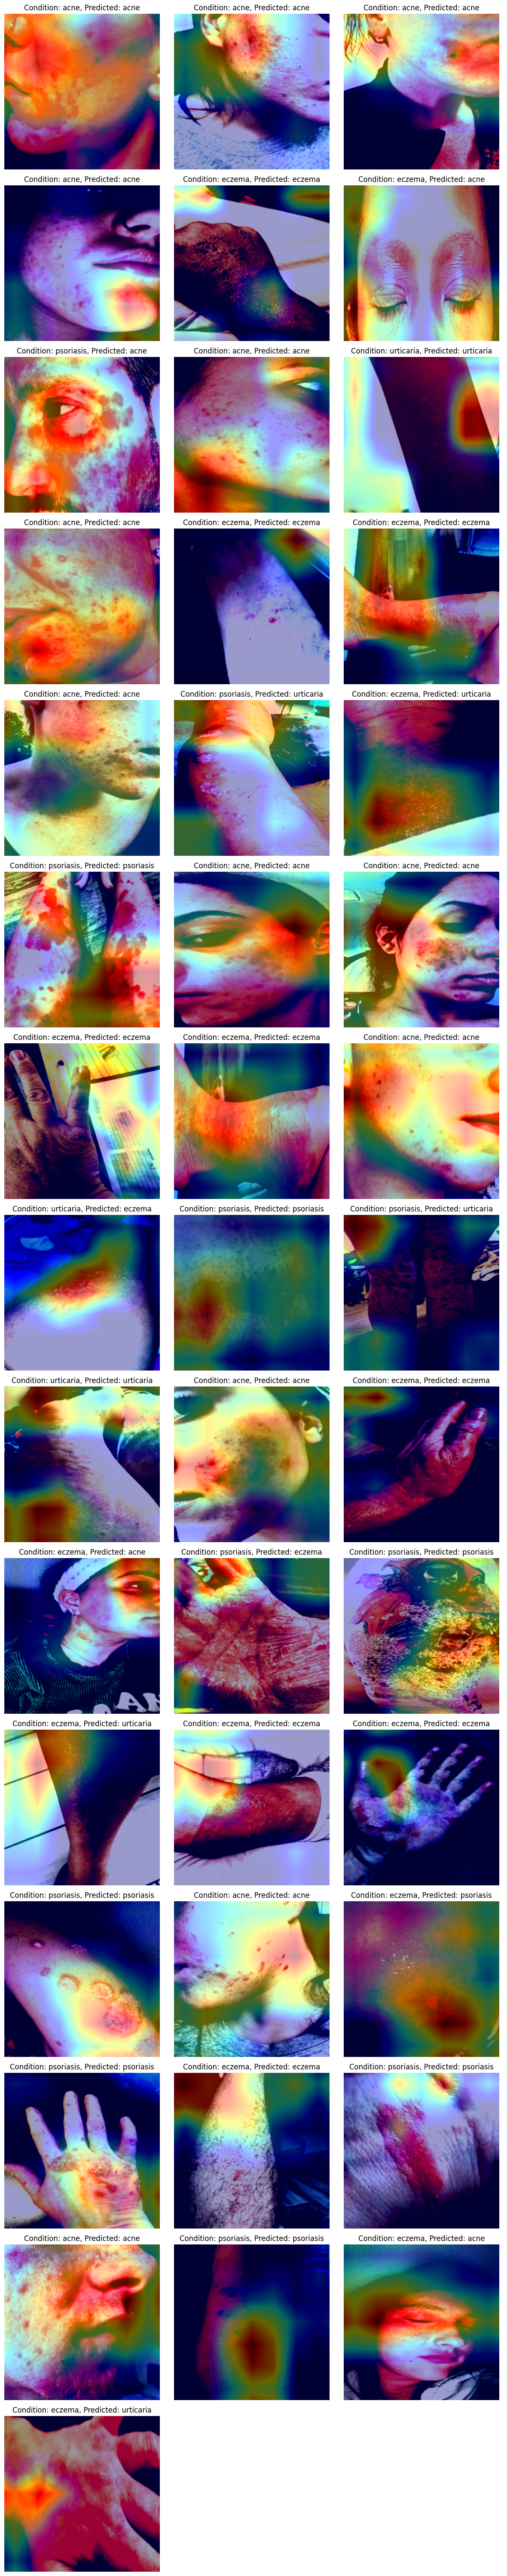

In [240]:
visualize_gradcams_with_colorbars(images_for_grad_cam, heatmaps,predicted_labels, real_labels)

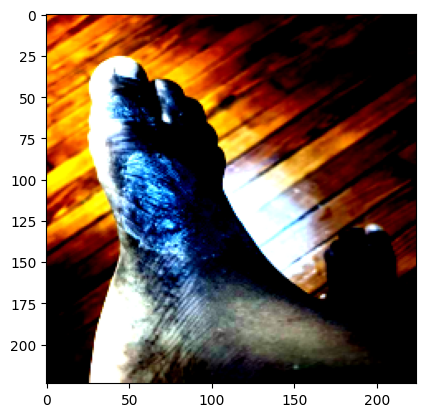

In [82]:
plt.imshow(img_np)
plt.show()